In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heart-closed-dataset/heart_2022_cleaned.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
# from sklearn.svm import LinearSVC,SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import AdaBoostClassifier
# IMPORT XGBOOST
from xgboost import XGBClassifier
import warnings
import pickle
from sklearn.preprocessing import OneHotEncoder
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
import scipy.sparse as sp

In [3]:
from sklearnex import patch_sklearn
from cuml.svm import SVC
import cupy
from cuml.manifold import TSNE

In [4]:
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [5]:
metrics={'times':{},'accuracies':{},'macro_f1s':{},'macro_f1s_train':{},'accuracies_train':{}}

In [6]:
def model_classifier(X_train,X_test,y_train,y_test,model,model_name):
    mod = model
    params = mod.get_params()
    print(params)
        
    print(mod)
    print(f"{model_name} training")
    start_time = time.time()
    mod.fit(X_train, y_train)
    end_time = time.time()
    y_pred = mod.predict(X_test)
    y_pred_train = mod.predict(X_train)
    
    accuracy = accuracy_score(y_test, y_pred)
    macro_f1 = f1_score(y_test, y_pred, average='macro')

    accuracy_train = accuracy_score(y_train, y_pred_train)
    macro_f1_train = f1_score(y_train, y_pred_train, average='macro')

    conf_matrix = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    metrics['times'][model_name] = (end_time-start_time)
    metrics['accuracies'][model_name] = accuracy
    metrics['macro_f1s'][model_name] = macro_f1
    metrics['accuracies_train'][model_name] = accuracy_train
    metrics['macro_f1s_train'][model_name] = macro_f1_train
    
    print("Accuracy:", accuracy)
    print("Macro f1:",macro_f1)
    print("Confusion Matrix:\n", conf_matrix)
    print("Classification Report:\n", report)
    return mod

### Reading the dataset and performing the train test split ###

In [7]:
data = pd.read_csv('/kaggle/input/heart-closed-dataset/heart_2022_cleaned.csv')
print(data.shape)
data.columns

(354862, 40)


Index(['State', 'Sex', 'GeneralHealth', 'PhysicalHealthDays',
       'MentalHealthDays', 'LastCheckupTime', 'PhysicalActivities',
       'SleepHours', 'RemovedTeeth', 'HadHeartAttack', 'HadAngina',
       'HadStroke', 'HadAsthma', 'HadSkinCancer', 'HadCOPD',
       'HadDepressiveDisorder', 'HadKidneyDisease', 'HadArthritis',
       'HadDiabetes', 'DeafOrHardOfHearing', 'BlindOrVisionDifficulty',
       'DifficultyConcentrating', 'DifficultyWalking',
       'DifficultyDressingBathing', 'DifficultyErrands', 'SmokerStatus',
       'ECigaretteUsage', 'ChestScan', 'RaceEthnicityCategory', 'AgeCategory',
       'HeightInMeters', 'WeightInKilograms', 'BMI', 'AlcoholDrinkers',
       'HIVTesting', 'FluVaxLast12', 'PneumoVaxEver', 'TetanusLast10Tdap',
       'HighRiskLastYear', 'CovidPos'],
      dtype='object')

In [8]:
categorical_features = data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_features

['State',
 'Sex',
 'GeneralHealth',
 'LastCheckupTime',
 'PhysicalActivities',
 'RemovedTeeth',
 'HadHeartAttack',
 'HadAngina',
 'HadStroke',
 'HadAsthma',
 'HadSkinCancer',
 'HadCOPD',
 'HadDepressiveDisorder',
 'HadKidneyDisease',
 'HadArthritis',
 'HadDiabetes',
 'DeafOrHardOfHearing',
 'BlindOrVisionDifficulty',
 'DifficultyConcentrating',
 'DifficultyWalking',
 'DifficultyDressingBathing',
 'DifficultyErrands',
 'SmokerStatus',
 'ECigaretteUsage',
 'ChestScan',
 'RaceEthnicityCategory',
 'AgeCategory',
 'AlcoholDrinkers',
 'HIVTesting',
 'FluVaxLast12',
 'PneumoVaxEver',
 'TetanusLast10Tdap',
 'HighRiskLastYear',
 'CovidPos']

In [9]:
numerical_columns = data.select_dtypes(include=['number']).columns
numerical_columns

Index(['PhysicalHealthDays', 'MentalHealthDays', 'SleepHours',
       'HeightInMeters', 'WeightInKilograms', 'BMI'],
      dtype='object')

In [10]:
# Perform train test split
# y = data['GeneralHealth']
# X = data.drop('GeneralHealth', axis=1)
standard_scaler = StandardScaler()  
label_encoder = LabelEncoder()


for i in categorical_features:
    data[i] = label_encoder.fit_transform(data[i])

X_train,X_test = train_test_split(data,test_size=0.2, random_state=42)
X_train.shape, X_test.shape


X_train[numerical_columns] = standard_scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = standard_scaler.transform(X_test[numerical_columns])

Y_test = X_test.pop('GeneralHealth')
Y_train = X_train.pop('GeneralHealth')

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
Y_train.reset_index(drop=True, inplace=True)
Y_test.reset_index(drop=True, inplace=True)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU
INFO:sklearnex: sklearn.utils.validation._assert_all_finite: running accelerated version on CPU


((283889, 39), (70973, 39), (283889,), (70973,))

## TSNE

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


[W] [11:50:55.102555] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
<class 'numpy.ndarray'>


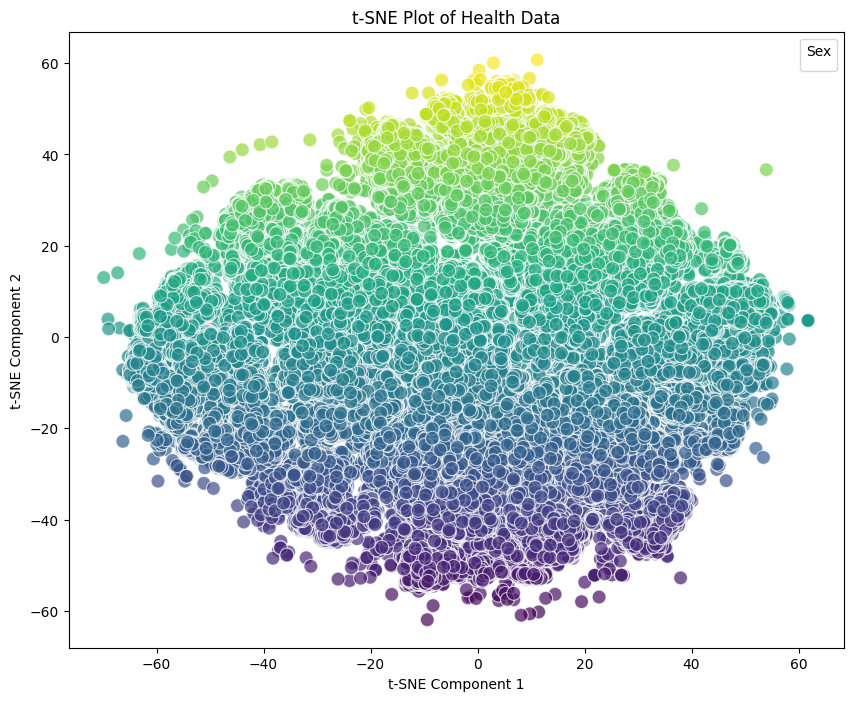

In [12]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_train).to_numpy()
print(type(tsne_results))
df=pd.DataFrame()
df['TSNE1'] = tsne_results[:, 0]
df['TSNE2'] = tsne_results[:, 1]
y=tsne_results[:, 1]

plt.figure(figsize=(10, 8))
sns.scatterplot(x='TSNE1', y='TSNE2', data=df, c=y, s=100, alpha=0.7)
plt.title('t-SNE Plot of Health Data')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Sex')
plt.show()


## PCA

In [ ]:
categorical_columns=categorical_features.copy()
categorical_columns.pop(categorical_columns.index('GeneralHealth'))


pca = PCA()
x_pca_2 = pca.fit(X_train[numerical_columns])
values = pca.explained_variance_ratio_

plt.figure(figsize = (10, 4))
ax = plt.subplot(111)

cumulative = np.cumsum(values)
ax.plot(cumulative)
plt.axhline(y=0.95, color='r', linestyle='-')
#print intersection point oh the red line with the curve

pca=PCA(n_components=4)
x_pca = pca.fit_transform(X_train[numerical_columns])

In [ ]:
x_pca=pca.transform(X_train[numerical_columns])
x_pca = pd.DataFrame(x_pca)
x_pca = pd.concat([x_pca,X_train[categorical_columns]],axis=1)
X_train=x_pca.to_numpy()

x_pca=pca.transform(X_test[numerical_columns])
x_pca = pd.DataFrame(x_pca)
x_pca = pd.concat([x_pca,X_test[categorical_columns]],axis=1)
X_test=x_pca.to_numpy()
X_train.shape, X_test.shape

## JL

In [ ]:
def create_matrix_feature(d,n):
    matrix = np.random.normal(loc=0, scale=1.0/np.sqrt(n), size=(d, n))
    return matrix
output_dim=20
matrix_1=create_matrix_feature(X_train.shape[1],20)

In [ ]:
# X_train=X_train.dot(matrix_1)
# X_test=X_test.dot(matrix_1)

### Naive Bayes ###

**Default**

In [ ]:
model_naive  = model_classifier(X_train,X_test,Y_train,Y_test,GaussianNB(),"Naive_Bayes")
pickle.dump(model_naive, open('naive_bayes_default.pkl', 'wb'))

### Logistic Regression ###

**Default**

In [ ]:
model_logistic = model_classifier(X_train,X_test,Y_train,Y_test,LogisticRegression(verbose=True),"Logistic_Regression")
pickle.dump(model_logistic, open('model_logistic_default.pkl', 'wb'))

In [ ]:
lr_model = LogisticRegression(random_state=42)

lr_param_grid = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1],           
    'solver': ['liblinear', 'saga'] 
}

lr_grid = GridSearchCV(lr_model, lr_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=-1)
print("-" * 20, "METRICS ON DATASET (Logistic Regression)", "-" * 20)
model_logistic = model_classifier(X_train,X_test,Y_train,Y_test,lr_grid,"Logistic_Regression")
pickle.dump(model_logistic, open('model_logistic_grid.pkl', 'wb'))

### Random Forest ###

**Default**

In [ ]:
model_rf = model_classifier(X_train,X_test,Y_train,Y_test,RandomForestClassifier(verbose=True,n_jobs=-1),"Random_Forest")
pickle.dump(model_rf, open('model_rf_default.pkl', 'wb'))

In [ ]:
rf_model = RandomForestClassifier(random_state=42)

rf_param_grid = {
    'n_estimators': [50, 100],       
    'max_depth': [None, 10],         
    'min_samples_split': [2, 5],     
    'min_samples_leaf': [1, 2]       
}

rf_grid = GridSearchCV(rf_model, rf_param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=4)
print("-" * 20, "METRICS ON DATASET (Random Forest)", "-" * 20)
model_rf = model_classifier(X_train,X_test,Y_train,Y_test,rf_grid,"Random_Forest")
pickle.dump(model_rf, open('model_rf_grid.pkl', 'wb'))

### Decision Tree ###

**Default**

In [ ]:
model_dt = model_classifier(X_train,X_test,Y_train,Y_test,DecisionTreeClassifier(),"Decision_Tree")
pickle.dump(model_dt, open('model_dt_default.pkl', 'wb'))

In [ ]:
dt_model = DecisionTreeClassifier(random_state=42)

dt_param_grid = {
    'criterion': ['gini', 'entropy'],     
    'max_depth': [5, 10],              
    'min_samples_split': [2, 5],          
    'min_samples_leaf': [1, 2]            
}

dt_grid = GridSearchCV(dt_model, dt_param_grid, cv=3, scoring='f1_macro', verbose=2, n_jobs=4)
print("-"*20,"METRICS ON DATASET", "-"*20)
model_dt_grid = model_classifier(X_train,X_test,Y_train,Y_test,dt_grid,"Decision_Tree")
pickle.dump(model_dt_grid, open('model_dt_grid.pkl', 'wb'))

### SVM ###

**Default**

In [ ]:
model_svm = model_classifier(X_train,X_test,Y_train,Y_test,SVC(verbose=True),"SVM")
pickle.dump(model_svm, open('model_svm_default.pkl', 'wb'))

### Ada Boost ###


**Default**

In [ ]:
model_ada = model_classifier(X_train,X_test,Y_train,Y_test,AdaBoostClassifier(),"ADA_Boost")
pickle.dump(model_ada, open('model_ada_default.pkl', 'wb'))

In [ ]:
ab_model = AdaBoostClassifier(random_state=42)

ab_param_grid = {
    'n_estimators': [50, 100],     
    'learning_rate': [0.01, 0.1, 1] 
}

ab_grid = GridSearchCV(ab_model, ab_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=4)
print("-" * 20, "METRICS ON DATASET (AdaBoost)", "-" * 20)
model_ada_grid = model_classifier(X_train,X_test,Y_train,Y_test,ab_grid,"ADA_Boost")
pickle.dump(model_ada_grid, open('model_ada_grid.pkl', 'wb'))

### XG Boost ###

**Default**

In [ ]:
model_xg = model_classifier(cupy.array(X_train),cupy.array(X_test),Y_train,Y_test,XGBClassifier(device='cuda'),"XG_Boost")
pickle.dump(model_xg, open('model_xg_default.pkl', 'wb'))

In [ ]:
xgb_model = XGBClassifier(random_state=42)

xgb_param_grid = {
    'n_estimators': [50, 100],     
    'learning_rate': [0.01, 0.1],
    'max_depth': [5, 7],      
    'subsample': [0.8, 1.0]    
}

# Setup GridSearchCV
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=3, scoring='f1_macro', verbose=4, n_jobs=4)

# Train and save the model
print("-" * 20, "METRICS ON DATASET (XGBoost)", "-" * 20)
model_xgb_grid = model_classifier(cupy.array(X_train), cupy.array(X_test), Y_train, Y_test, xgb_grid, "XG_Boost")
pickle.dump(model_xgb_grid, open('model_xgb_grid.pkl', 'wb'))


In [ ]:
df = pd.DataFrame(metrics)
df.to_csv("Metrics.csv")
df

In [ ]:
models = [df.index[i] for i in range(df.shape[0])]
metrics = [df.columns[i] for i in range(df.shape[1])]

fig,axes = plt.subplots(5,figsize=(12,20))

for i in range(len(metrics)):
    # print(i)
    # print(row)
    row = df.iloc[:,i]
    axes[i].set_title(f"{metrics[i]} v/s Models")
    axes[i].set_xlabel("Model")
    axes[i].set_ylabel(f"{metrics[i]}")
    axes[i].plot(models,row,color='blue')
    
plt.tight_layout()
plt.savefig("Metrics.png")
plt.show()